<a href="https://colab.research.google.com/github/pauljune5052-CET/ADALL_github/blob/main/Healthcare_7075157p_ADALL_Project__Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project Revision (Classification): Predicting of Healthcare Patient readmission status


In [1]:
!pip -q install -U \
  scikit-learn==1.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 46.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
print("Setup complete")

Setup complete


In [3]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.8.0


In [4]:
# ------------------------------------------------------------
# LOAD DATA (do first)
# Tip: if this block is slow, run it early.
# ------------------------------------------------------------

github_raw_url = "https://raw.githubusercontent.com/pauljune5052-CET/ADALL_github/refs/heads/main/healthcare_patient_status.csv"

df = pd.read_csv(github_raw_url)
print("Successfully loaded data from GitHub!")
display(df.head())

Successfully loaded data from GitHub!


,patient_id,age,gender,chronic_condition,admission_type,department,wait_time_min,length_of_stay_days,procedures_count,medication_count,complications,discharge_status,readmitted_30d,total_billing,satisfaction_score
0,1,69,male,0,scheduled,Neurology,41,2,0,3,1,referred,1,2160,2
1,2,38,male,0,emergency,Oncology,17,3,1,2,0,recovered,0,3090,3
2,3,81,male,0,scheduled,Neurology,40,2,3,2,0,recovered,0,3165,3
3,4,67,female,1,emergency,A&E,7,4,5,9,0,recovered,0,6105,3
4,5,88,male,1,emergency,Cardiology,34,3,7,5,0,recovered,1,5700,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           3000 non-null   int64 
 1   age                  3000 non-null   int64 
 2   gender               3000 non-null   object
 3   chronic_condition    3000 non-null   int64 
 4   admission_type       3000 non-null   object
 5   department           3000 non-null   object
 6   wait_time_min        3000 non-null   int64 
 7   length_of_stay_days  3000 non-null   int64 
 8   procedures_count     3000 non-null   int64 
 9   medication_count     3000 non-null   int64 
 10  complications        3000 non-null   int64 
 11  discharge_status     3000 non-null   object
 12  readmitted_30d       3000 non-null   int64 
 13  total_billing        3000 non-null   int64 
 14  satisfaction_score   3000 non-null   int64 
dtypes: int64(11), object(4)
memory usage: 351.7+ KB



##Step 2) Dataset profile (no charts yet)



In [6]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [7]:
data_preview = df.head(10).to_string()
print(data_preview)

   patient_id  age  gender  chronic_condition admission_type  department  wait_time_min  length_of_stay_days  procedures_count  medication_count  complications discharge_status  readmitted_30d  total_billing  satisfaction_score
0           1   69    male                  0      scheduled   Neurology             41                    2                 0                 3              1         referred               1           2160                   2
1           2   38    male                  0      emergency    Oncology             17                    3                 1                 2              0        recovered               0           3090                   3
2           3   81    male                  0      scheduled   Neurology             40                    2                 3                 2              0        recovered               0           3165                   3
3           4   67  female                  1      emergency         A&E              7 

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Use ONLY the information inside the dataset profile text.
Do NOT invent correlations, columns, or values.
If something is not in the dataset profile, state 'Not shown in profile'.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""Dataset info: {data_preview}\n
    Context:
    The business problem is that we want to predict whether a patient will be readmitted to the hospital within 30 days.\n
    Questions
    1. Based on the context and dataset info, how should i approach modelling objective? focus on problem framing aspects.
    2. What would be the most meaningful target?
    3. What would be most important metric for scoring?
    4. What are the top 3 most potentially important features?
    """)
print(response.output_text)

Short answers first, then brief justification traces based only on the dataset profile you provided.

1) How to approach the modelling objective (problem framing)
- Frame this as a supervised binary classification problem: target = readmitted_30d (0/1).
- Use tree-based classifiers (e.g., Random Forest, Gradient Boosting) because the dataset contains a mix of numeric and categorical features (age, wait_time_min, length_of_stay_days, procedures_count, medication_count, total_billing, chronic_condition, gender, admission_type, department, discharge_status, complications, satisfaction_score) and trees handle mixed types without scaling.
- Prepare standard ML steps: clean data (detect missing values — Not shown in profile), encode categorical variables (one-hot / target / ordinal as appropriate), split with stratified CV on the readmitted_30d label (the small sample shows imbalance — see below), tune hyperparameters with cross-validation, and produce probability outputs for thresholding.
-

In [8]:
df.columns

Index(['patient_id', 'age', 'gender', 'chronic_condition', 'admission_type',
       'department', 'wait_time_min', 'length_of_stay_days',
       'procedures_count', 'medication_count', 'complications',
       'discharge_status', 'readmitted_30d', 'total_billing',
       'satisfaction_score'],
      dtype='object')

In [9]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
patient_id              int64
age                     int64
gender                 object
chronic_condition       int64
admission_type         object
department             object
wait_time_min           int64
length_of_stay_days     int64
procedures_count        int64
medication_count        int64
complications           int64
discharge_status       object
readmitted_30d          int64
total_billing           int64
satisfaction_score      int64

=== NUMERIC DESCRIBE ===
        patient_id          age  chronic_condition  wait_time_min  length_of_stay_days  procedures_count  medication_count  complications  readmitted_30d  total_billing  satisfaction_score
count  3000.000000  3000.000000        3000.000000    3000.000000          3000.000000       3000.000000       3000.000000    3000.000000     3000.000000    3000.000000         3000.000000
mean   1500.500000    53.051333           0.405667      33.326333             3.535000          2.435667          3.404667       0.

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile, what data quality issues should be resolved before modelling?
Provide a priority list and justify each item. \n
2. Which columns appear redundant, correlated, or likely to cause leakage?
Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")
print(response.output_text)

Below are (A) prioritized data-quality issues to resolve before modelling with justification strictly drawn from the provided dataset profile, (B) columns that look redundant / correlated / likely to cause leakage (with why), and (C) a Python cleaning script that implements one helper function per identified issue plus a wrapper that calls them based on user-provided booleans. The script does NOT encode categoricals or build a model (per your request).

A — Priority list of data-quality issues (highest → lowest), with reasons based only on dataset profile
1) Remove unique identifier (patient_id) — HIGH priority
   - Reason: patient_id is unique per row (unique_count = 3000, listed as possible leakage column). Unique IDs add no predictive signal but can cause overfitting or accidental leakage if used as a feature. Profile explicitly flagged it as "possible leakage" and unique for each row.

2) Correct dtypes / mark categorical and binary columns — HIGH priority
   - Reason: Several colu

In [10]:
import pandas as pd
import numpy as np

# Helper 1: Remove the unique identifier (leakage)
def drop_patient_id(df: pd.DataFrame, drop: bool = True, id_col: str = "patient_id") -> pd.DataFrame:
    """
    Drops the patient_id column if drop=True.
    Justification (from dataset profile): patient_id is unique for each row and is flagged as possible leakage.
    """
    df = df.copy()
    if drop and id_col in df.columns:
        df = df.drop(columns=[id_col])
    return df

# Helper 2: Convert appropriate columns to categorical dtype (without encoding)
def convert_dtypes_to_category(df: pd.DataFrame,
                               categorical_cols: list = None,
                               binary_int_cols: list = None) -> pd.DataFrame:
    """
    Convert specified columns to 'category' dtype. Defaults selected from dataset profile:
      categorical: gender, admission_type, department, discharge_status
      binary int: chronic_condition, complications, readmitted_30d
    Does NOT perform label encoding; only sets dtype to 'category'.
    """
    df = df.copy()
    if categorical_cols is None:
        categorical_cols = ["gender", "admission_type", "department", "discharge_status"]
    if binary_int_cols is None:
        binary_int_cols = ["chronic_condition", "complications", "readmitted_30d"]
    for col in categorical_cols + binary_int_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")
    return df

# Helper 3: Winsorize / cap numeric outliers while excluding known binary or target columns
def winsorize_numeric(df: pd.DataFrame,
                      lower_quantile: float = 0.01,
                      upper_quantile: float = 0.99,
                      exclude_cols: list = None,
                      exclude_binary: bool = True) -> pd.DataFrame:
    """
    Caps numeric columns at the given quantiles. Excludes:
      - columns in exclude_cols
      - binary columns (unique values == 2) if exclude_binary=True
      - object/category columns
      - the target 'readmitted_30d' if present (should be in exclude_cols by default)
    Uses quantile capping to preserve rows (preferred to deletion for healthcare data).
    """
    df = df.copy()
    if exclude_cols is None:
        exclude_cols = []
    # ensure target excluded
    if "readmitted_30d" in df.columns and "readmitted_30d" not in exclude_cols:
        exclude_cols = exclude_cols + ["readmitted_30d"]
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col in exclude_cols:
            continue
        # Skip binary-like columns when requested
        if exclude_binary:
            unique_vals = df[col].nunique(dropna=False)
            if unique_vals <= 2:
                continue
        # Skip patient_id-like or identifiers if accidentally present
        if col.lower() == "patient_id":
            continue
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        # If column already bounded (e.g., satisfaction_score 1-5) this will be no-op
        df[col] = df[col].clip(lower=lower, upper=upper)
    return df

# Helper 4: Drop highly correlated numeric features (automated selection)
def drop_highly_correlated(df: pd.DataFrame,
                           corr_threshold: float = 0.90,
                           target_col: str = "readmitted_30d",
                           prefer_keep: list = None) -> (pd.DataFrame, list):
    """
    Detects numeric column pairs with absolute Pearson correlation > corr_threshold.
    For each pair, drops the column that is more redundant:
      - If prefer_keep is provided and one column of the pair is in prefer_keep, keep that one.
      - Otherwise, compute mean absolute correlation of each column with all others and drop the one with higher mean abs-correlation (more redundant).
    Returns cleaned df and list of dropped columns.
    Justification from dataset profile: total_billing has corr 0.919 with length_of_stay_days, so one should be removed or reviewed.
    """
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude target from being dropped
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    corr = df[numeric_cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    if prefer_keep is None:
        prefer_keep = []
    for col in upper.columns:
        # find columns to drop based on threshold
        high_pairs = upper.index[upper[col] > corr_threshold].tolist()
        for other in high_pairs:
            if other in to_drop or col in to_drop:
                continue
            # prefer to keep columns in prefer_keep
            if col in prefer_keep and other not in prefer_keep:
                drop_candidate = other
            elif other in prefer_keep and col not in prefer_keep:
                drop_candidate = col
            else:
                # compute mean abs-correlation with other columns
                mean_col = corr[col].mean()
                mean_other = corr[other].mean()
                # drop the one with larger mean correlation (more redundant)
                drop_candidate = col if mean_col > mean_other else other
            to_drop.add(drop_candidate)
    # Apply dropping
    to_drop = [c for c in to_drop if c in df.columns]
    df = df.drop(columns=to_drop)
    return df, to_drop

# Helper 5: Check missing values and optionally impute simple strategy (median for numeric, mode for categoricals)
def check_missing_and_impute(df: pd.DataFrame, impute: bool = False) -> pd.DataFrame:
    """
    Reports missing value counts and, if impute=True, fills:
      - numeric columns with median
      - categorical columns with mode
    Dataset profile currently shows no nulls, so impute will usually be a no-op.
    """
    df = df.copy()
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        # No missing values
        return df
    if not impute:
        # Return as-is; user may inspect missing
        return df
    # Impute numeric with median, categorical with mode
    for col in df.columns:
        if df[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df

# Wrapper function that calls helpers based on boolean switches
def preprocess_wrapper(df: pd.DataFrame,
                       drop_id: bool = True,
                       convert_dtypes: bool = True,
                       winsorize: bool = True,
                       drop_correlated: bool = True,
                       impute_missing: bool = False,
                       corr_threshold: float = 0.90,
                       prefer_keep: list = None) -> (pd.DataFrame, dict):
    """
    Runs a sequence of cleaning steps. Returns (cleaned_df, diagnostics_dict)
    diagnostics_dict contains lists of dropped columns and other useful info.
    Steps (in order):
      1) Optionally drop patient_id
      2) Optionally convert dtypes to categorical for known categorical/binary cols
      3) Optionally winsorize numeric columns (caps at 1st/99th percentile by default)
      4) Optionally drop highly correlated numeric features (threshold default 0.90)
      5) Optionally check/impute missing values
    Does NOT encode categorical variables or perform modelling.
    """
    diagnostics = {"dropped_columns": [], "winsorized": False, "imputed": False}
    df_work = df.copy()

    # Step 1: drop id
    df_work = drop_patient_id(df_work, drop=drop_id)
    if drop_id:
        diagnostics["dropped_columns"].append("patient_id")

    # Step 2: convert dtypes
    if convert_dtypes:
        df_work = convert_dtypes_to_category(df_work)

    # Step 3: winsorize numeric (exclude binary & target)
    if winsorize:
        # default exclude list: target
        exclude = ["readmitted_30d"]
        df_work = winsorize_numeric(df_work, exclude_cols=exclude, exclude_binary=True)
        diagnostics["winsorized"] = True

    # Step 4: drop highly correlated
    dropped_corr = []
    if drop_correlated:
        df_work, dropped_corr = drop_highly_correlated(df_work,
                                                       corr_threshold=corr_threshold,
                                                       target_col="readmitted_30d",
                                                       prefer_keep=prefer_keep)
        diagnostics["dropped_columns"].extend(dropped_corr)

    # Step 5: missing values check/impute
    if impute_missing:
        df_work = check_missing_and_impute(df_work, impute=True)
        diagnostics["imputed"] = True

    return df_work, diagnostics

In [11]:
df_work, diagnostics = preprocess_wrapper(df)

In [12]:
df_work.head()

,age,gender,chronic_condition,admission_type,department,wait_time_min,length_of_stay_days,procedures_count,medication_count,complications,discharge_status,readmitted_30d,satisfaction_score
0,69,male,0,scheduled,Neurology,41.0,2,0,3,1,referred,1,2
1,38,male,0,emergency,Oncology,17.0,3,1,2,0,recovered,0,3
2,81,male,0,scheduled,Neurology,40.0,2,3,2,0,recovered,0,3
3,67,female,1,emergency,A&E,7.0,4,5,9,0,recovered,0,3
4,88,male,1,emergency,Cardiology,34.0,3,7,5,0,recovered,1,3


In [13]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  3000 non-null   int64   
 1   gender               3000 non-null   category
 2   chronic_condition    3000 non-null   category
 3   admission_type       3000 non-null   category
 4   department           3000 non-null   category
 5   wait_time_min        3000 non-null   float64 
 6   length_of_stay_days  3000 non-null   int64   
 7   procedures_count     3000 non-null   int64   
 8   medication_count     3000 non-null   int64   
 9   complications        3000 non-null   category
 10  discharge_status     3000 non-null   category
 11  readmitted_30d       3000 non-null   category
 12  satisfaction_score   3000 non-null   int64   
dtypes: category(7), float64(1), int64(5)
memory usage: 162.2 KB


In [14]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df_work.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df_work.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df_work.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df_work.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df_work.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df_work.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df_work.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df_work[num_cols].quantile(0.25)
Q3 = df_work[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df_work.columns[df_work.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df_work.duplicated().sum()
constant_cols = df_work.columns[df_work.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df_work.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
age                       int64
gender                 category
chronic_condition      category
admission_type         category
department             category
wait_time_min           float64
length_of_stay_days       int64
procedures_count          int64
medication_count          int64
complications          category
discharge_status       category
readmitted_30d         category
satisfaction_score        int64

=== NUMERIC DESCRIBE ===
               age  wait_time_min  length_of_stay_days  procedures_count  medication_count  satisfaction_score
count  3000.000000    3000.000000          3000.000000       3000.000000       3000.000000         3000.000000
mean     53.051333      33.250100             3.530667          2.430667          3.400333            2.803000
std      20.704901      16.896223             2.011734          1.578826          1.876497            0.838506
min      18.000000       5.000000             1.000000          0.000000          0.000000         

In [15]:
X=df_work.drop('readmitted_30d', axis=1)
y=df_work['readmitted_30d']

In [16]:
X

,age,gender,chronic_condition,admission_type,department,wait_time_min,length_of_stay_days,procedures_count,medication_count,complications,discharge_status,satisfaction_score
0,69,male,0,scheduled,Neurology,41.0,2,0,3,1,referred,2
1,38,male,0,emergency,Oncology,17.0,3,1,2,0,recovered,3
2,81,male,0,scheduled,Neurology,40.0,2,3,2,0,recovered,3
3,67,female,1,emergency,A&E,7.0,4,5,9,0,recovered,3
4,88,male,1,emergency,Cardiology,34.0,3,7,5,0,recovered,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,40,male,0,emergency,Cardiology,41.0,1,2,1,0,recovered,3
2996,21,male,1,scheduled,Polyclinic,54.0,3,3,2,0,recovered,2
2997,72,male,0,scheduled,Neurology,38.0,1,3,2,0,recovered,2
2998,33,female,0,scheduled,Neurology,28.0,2,4,2,0,recovered,2



##Step 5) Create the target: number of failed subjects (special target)

Here you convert **three subject grades** into **one target**:

- A subject is considered **failed** when grade `< 10`.
- You count how many of the three subjects are failed.

### Common mistakes to avoid
- Using `<= 10` by accident (that changes the definition).
- Counting missing values as fails (check for missing grades first).
- Forgetting to confirm the **range** of the new target (it should usually be 0–3).


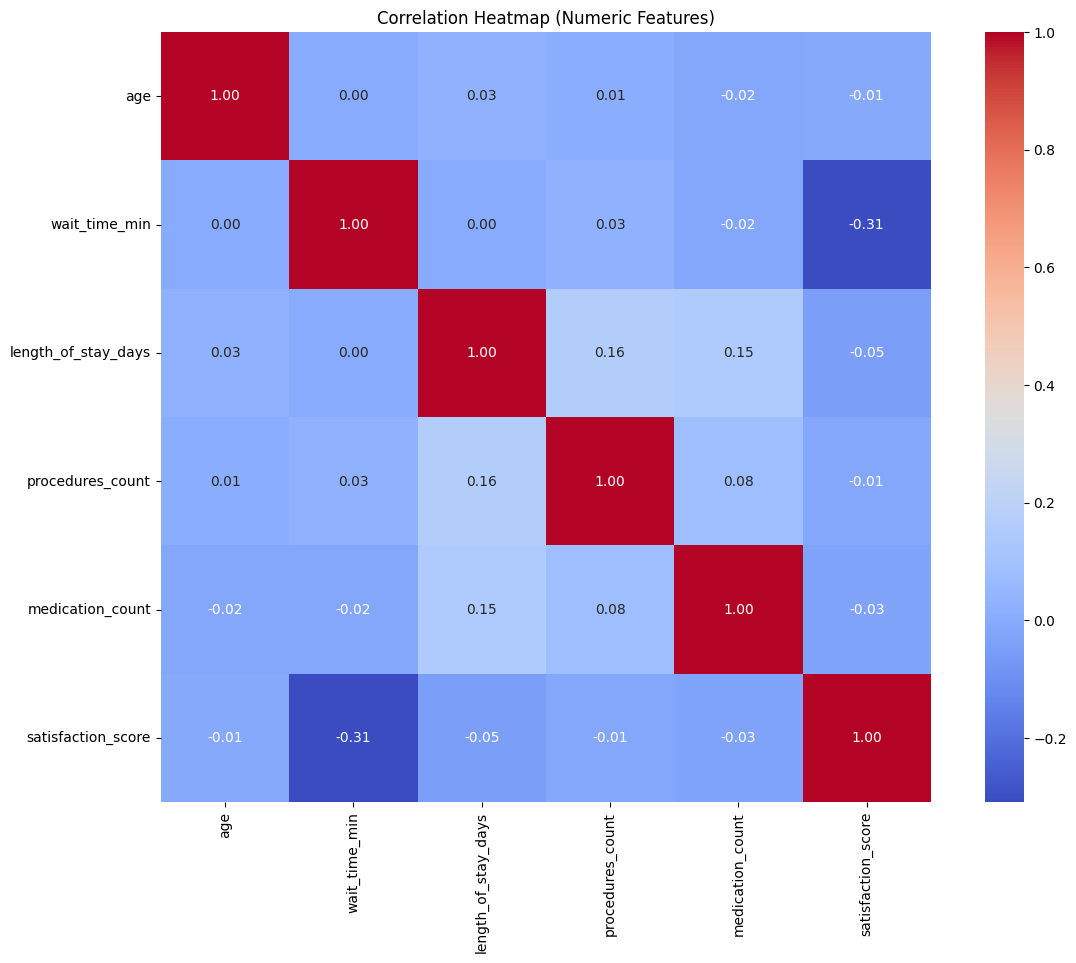

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df_work.select_dtypes(include="number").columns

corr_matrix = df_work[num_cols].corr()

plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [18]:
cols_to_drop = ['readmitted_30d']  # Target
df_work1 = df_work.copy()
df_work1 = df_work1.drop(columns=cols_to_drop)

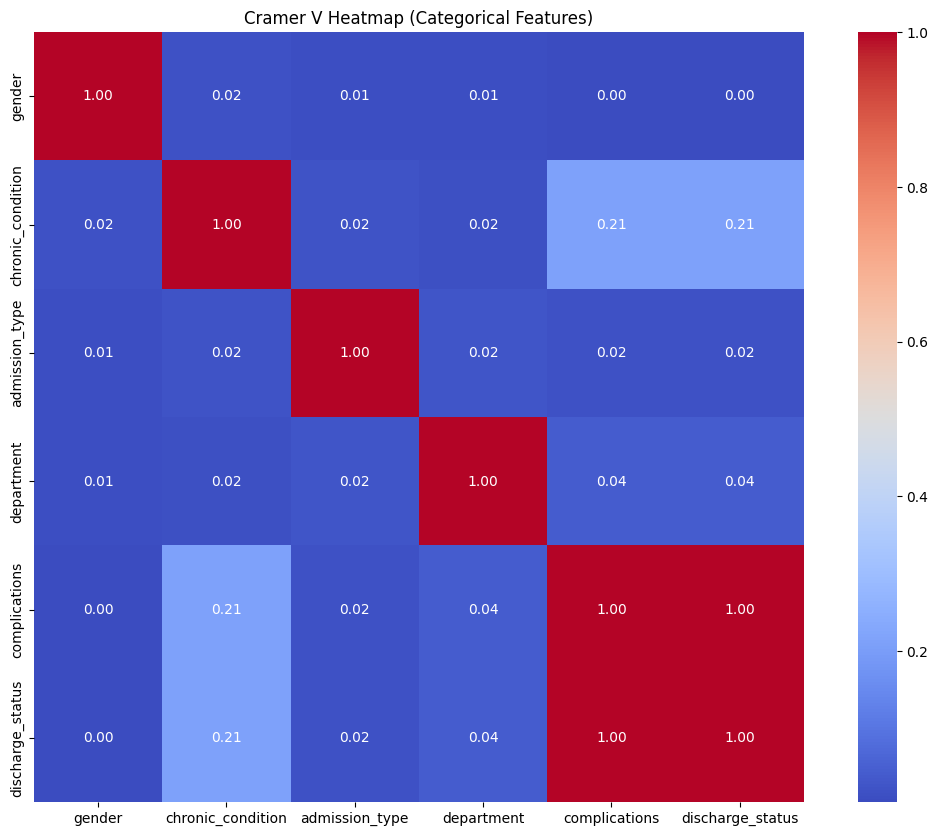

In [19]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_cols = df_work1.select_dtypes(include=["object", "category"]).columns

cramers_matrix = pd.DataFrame(index=cat_cols,columns=cat_cols,dtype=float)


for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df_work1[col1], df_work1[col2])

plt.figure(figsize=(14,10))
sns.heatmap(
    cramers_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)

plt.title("Cramer V Heatmap (Categorical Features)")
plt.show()

In [20]:
df_work["readmitted_30d"].value_counts()

,count
readmitted_30d,
0,2296
1,704


In [21]:
df_work.shape

(3000, 13)


##Step 6) Split into train and test sets

**Goal:** ensure you evaluate on unseen data.

Revision reminders:
- Use the same `random_state` for reproducibility.
- For regression, you usually do **not** stratify (unless you bucket the target).
- Keep the test set untouched until final evaluation.


In [22]:
X=df_work.drop('readmitted_30d', axis=1)
y=df_work['readmitted_30d']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((2400, 12), (600, 12))

In [23]:
#value count for y_train and y_test
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


readmitted_30d
0    0.765417
1    0.234583
Name: proportion, dtype: float64
readmitted_30d
0    0.765
1    0.235
Name: proportion, dtype: float64



##Step 7) Preprocessing (critical for mixed columns)

Most real datasets contain both:
- numeric columns (need scaling sometimes, missing values handling)
- categorical columns (need encoding, missing values handling)

**Tip:** In a practical test, a clean `ColumnTransformer` + `Pipeline` is often the best answer because:
- it reduces leakage,
- it ensures the same steps apply to train and test,
- it makes your workflow reproducible.


In [24]:
num_cols = X_train.select_dtypes(exclude=["object","category"]).columns
cat_cols = X_train.select_dtypes(include=["object","category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

num_cols[:10], cat_cols[:10]


(Index(['age', 'wait_time_min', 'length_of_stay_days', 'procedures_count',
        'medication_count', 'satisfaction_score'],
       dtype='object'),
 Index(['gender', 'chronic_condition', 'admission_type', 'department',
        'complications', 'discharge_status'],
       dtype='object'))

In [25]:
# Random Forest Preprocessor

rf_preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), cat_cols),
    ],
    remainder="drop"
)

# XGBoost Preprocessor

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False
        ), cat_cols),
    ],
    remainder="drop"
)

In [26]:
xgb_preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [27]:
X_train.head()

,age,gender,chronic_condition,admission_type,department,wait_time_min,length_of_stay_days,procedures_count,medication_count,complications,discharge_status,satisfaction_score
1738,45,female,0,emergency,Oncology,12.0,4,1,4,0,recovered,3
960,71,female,0,emergency,Polyclinic,17.0,8,2,2,0,recovered,3
383,78,female,1,scheduled,Oncology,45.0,5,2,3,1,referred,3
2563,18,male,0,emergency,Cardiology,63.0,2,2,2,1,referred,3
1696,60,male,0,emergency,Cardiology,24.0,4,2,3,0,recovered,2



##Step 8) Build a model pipeline

**Revision goal:** You should be able to explain:
- What the preprocessor does
- What the model does
- Why a pipeline prevents mistakes

### Special note for this target
Even though the true target is a small set of integers, your regression model might output non-integers.
That is normal.

If the task requires integer predictions, you can *post-process* predictions (rounding),
but only do this if instructed, and always state the trade-off (it can change metrics).



In [28]:
# Decision Tree (Classification) + GridSearch (MCC) + Print Tree

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

# Stratified CV keeps class balance similar across splits
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# MCC scorer (higher is better)
mcc_scorer = make_scorer(matthews_corrcoef)

# -------------------------------------------
# 1) Pipeline
# -------------------------------------------
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# -------------------------------------------
# 2) Small param grid (fast)
# -------------------------------------------
param_grid_dt = {
    "classifier__max_depth": [8, 15], #lets use a deeper tree to illustrate the need for Feature Importance
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}

# -------------------------------------------
# 3) GridSearchCV
# -------------------------------------------
gs_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv,
    scoring=mcc_scorer,
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4) Fit
# -------------------------------------------
gs_dt.fit(X_train, y_train)
print("Decision Tree grid search complete.")
print("Best DT Params:", gs_dt.best_params_)
print("Best CV MCC:", gs_dt.best_score_)

# -------------------------------------------
# 5) Test MCC
# -------------------------------------------
dt_best = gs_dt.best_estimator_
dt_pred = dt_best.predict(X_test)
#print("\nTest MCC (Decision Tree):", matthews_corrcoef(y_test, dt_pred))

# -------------------------------------------
# 6) Print the tree rules (text)
# -------------------------------------------
# Get feature names after preprocessing (works for ColumnTransformer in recent sklearn)
#pre = dt_best.named_steps["preprocessor"]
#clf = dt_best.named_steps["classifier"]

print("\nTest MCC (Decision Tree):", matthews_corrcoef(y_test, dt_pred))
print("Best (DT) Params:", gs_dt.best_params_)
print("\nTest Classification Report:\n", classification_report(y_test, dt_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Decision Tree grid search complete.
Best DT Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 8}
Best CV MCC: 0.19353420026958593

Test MCC (Decision Tree): 0.24824993984452498
Best (DT) Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 8}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       459
           1       0.53      0.26      0.34       141

    accuracy                           0.77       600
   macro avg       0.67      0.59      0.60       600
weighted avg       0.74      0.77      0.74       600

Test Confusion Matrix:
 [[427  32]
 [105  36]]


In [35]:
# Get feature names after preprocessing (works for ColumnTransformer in recent sklearn)
pre = dt_best.named_steps["preprocessor"]
clf = dt_best.named_steps["classifier"]
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    feature_names = [f"f{i}" for i in range(clf.n_features_in_)]

tree_text = export_text(clf, feature_names=list(feature_names), max_depth=6)
print("\nDecision Tree (first 6 levels):\n")
print(tree_text)


Decision Tree (first 6 levels):

|--- cat__chronic_condition_0 <= 0.50
|   |--- cat__complications_0 <= 0.50
|   |   |--- num__medication_count <= 2.73
|   |   |   |--- num__length_of_stay_days <= 1.48
|   |   |   |   |--- num__age <= -1.62
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- num__age >  -1.62
|   |   |   |   |   |--- cat__department_Oncology <= 0.50
|   |   |   |   |   |   |--- num__wait_time_min <= -1.23
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- num__wait_time_min >  -1.23
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- cat__department_Oncology >  0.50
|   |   |   |   |   |   |--- num__wait_time_min <= -0.01
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- num__wait_time_min >  -0.01
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- num__length_of_stay_days >  1.48
|   |   |   |   |--- num__wait_time_min <= -1.35
|   |   |   |   |

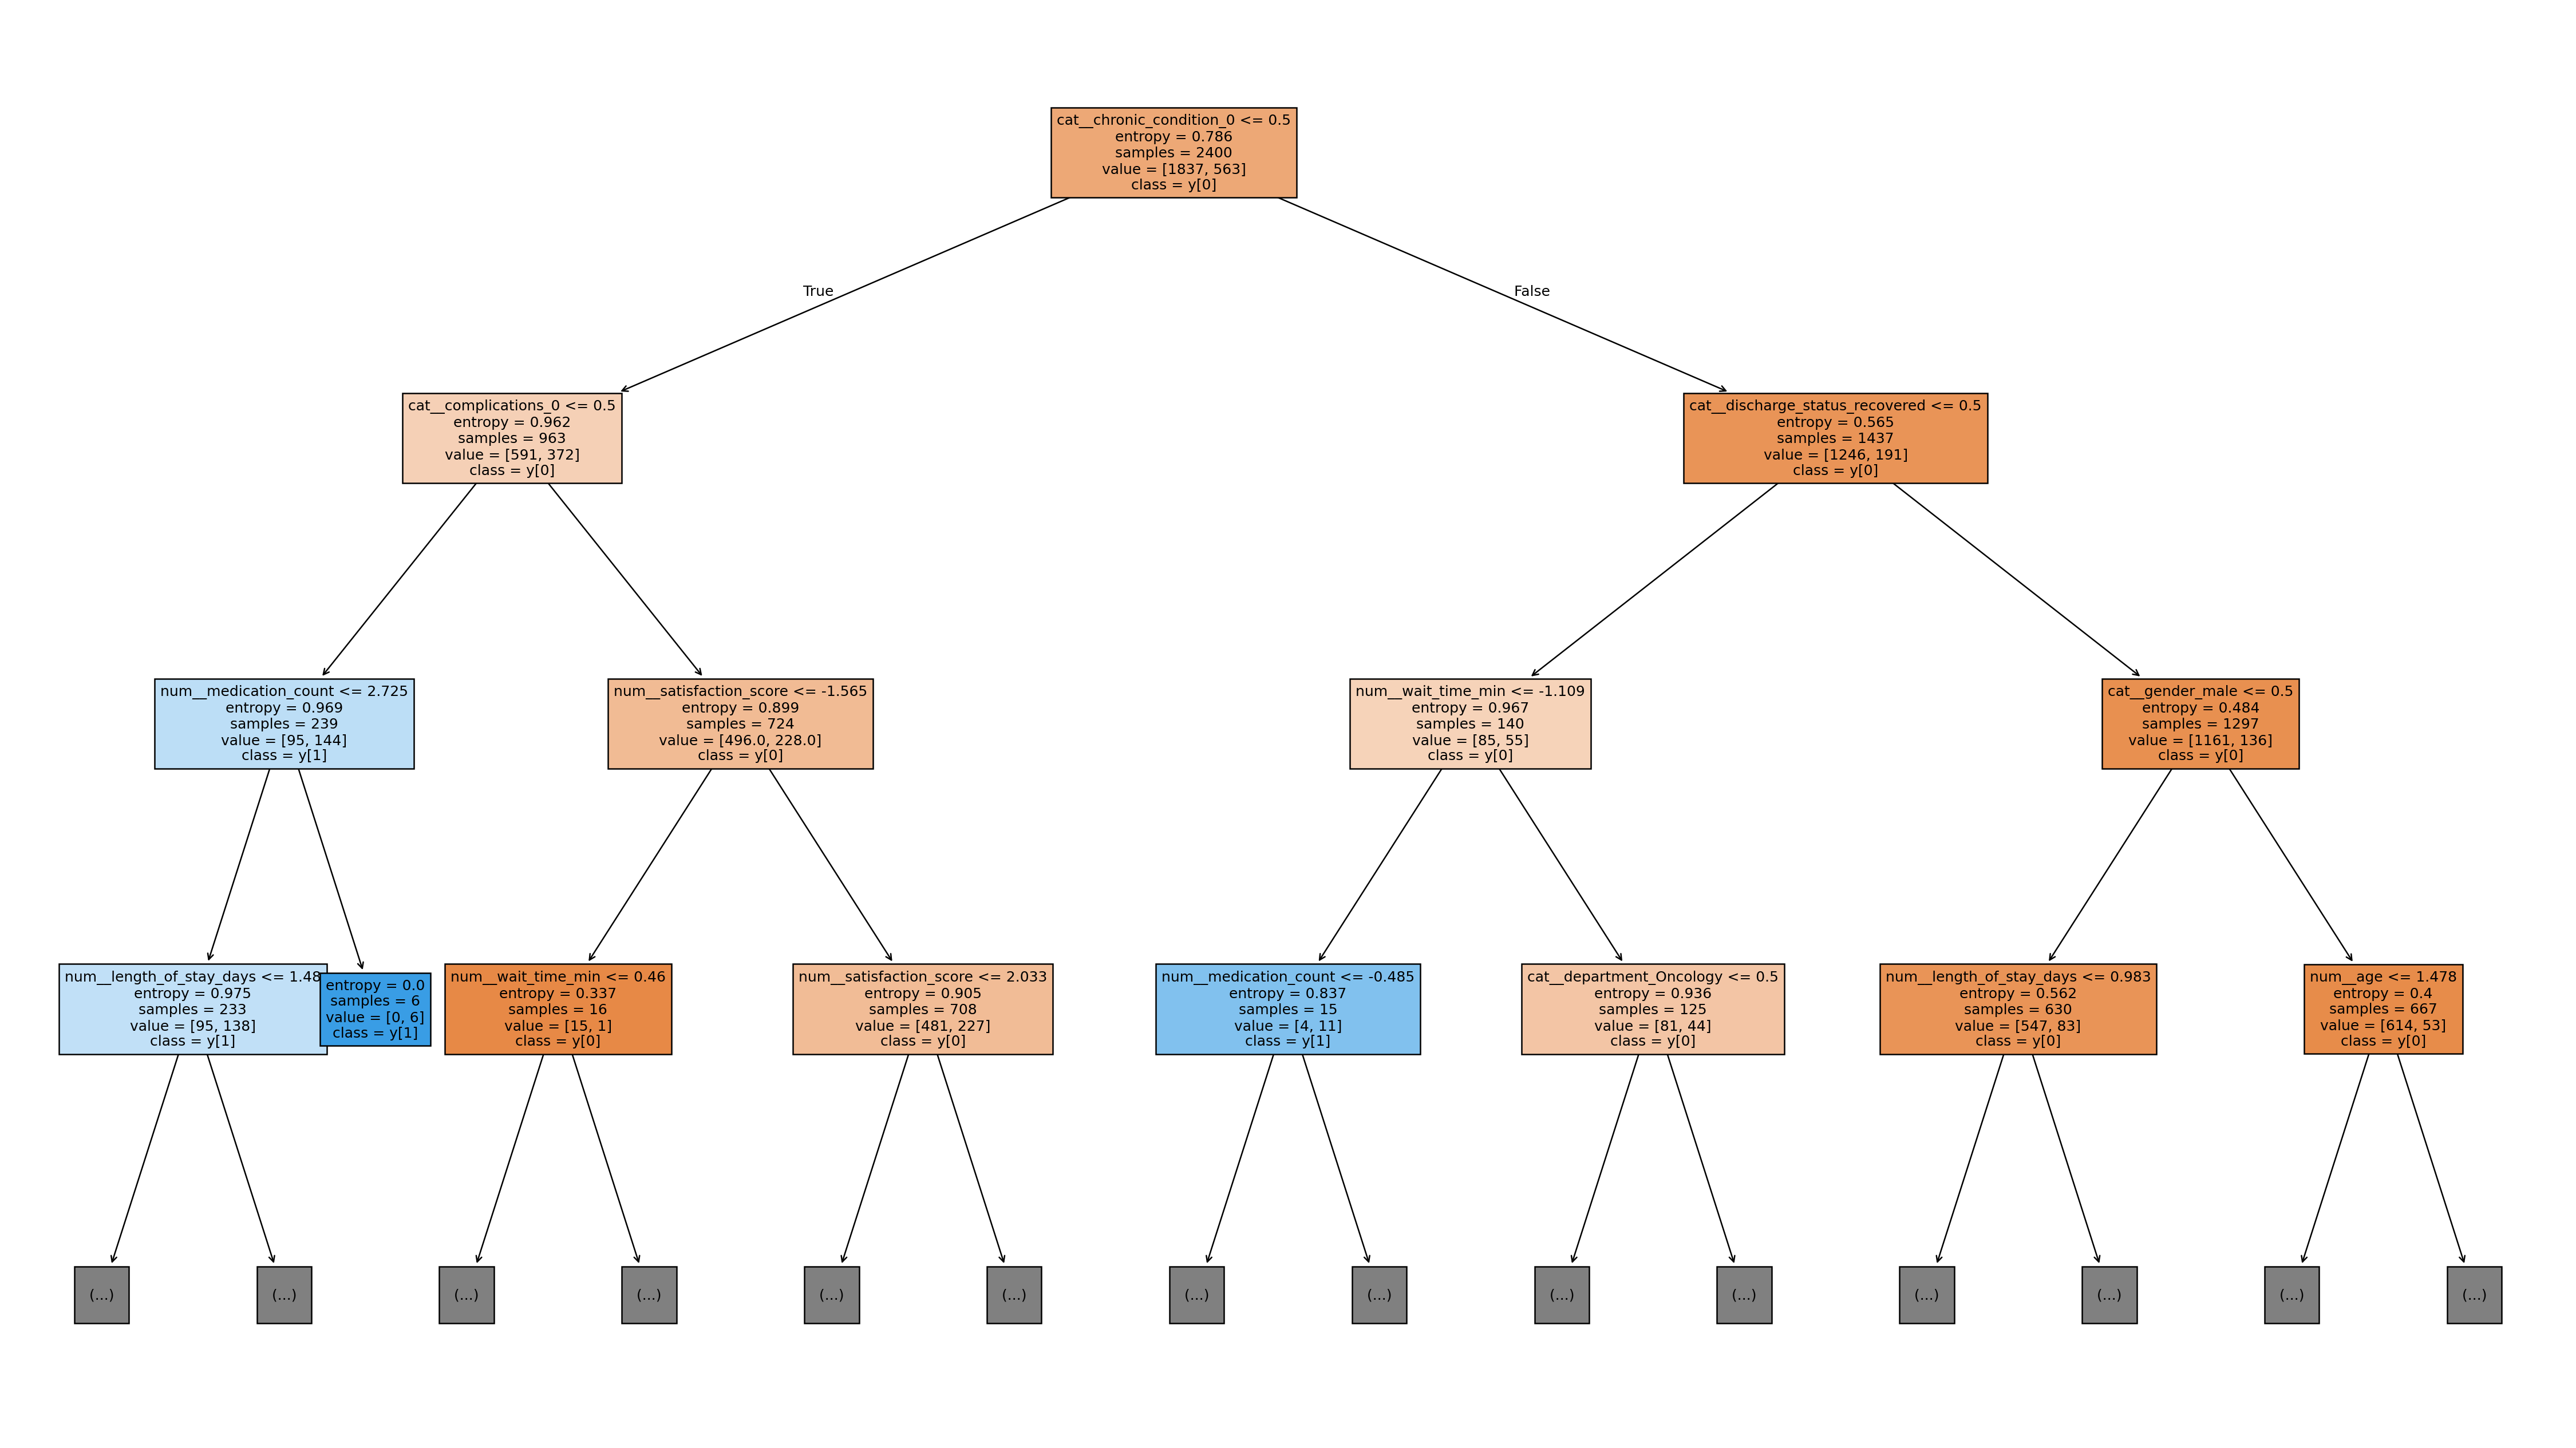

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(32, 18),dpi=180)
plot_tree(clf, feature_names=feature_names, class_names=True, filled=True, max_depth=3,fontsize=10)
plt.show()

In [31]:
import pandas as pd

dt_preproc = dt_best.named_steps["preprocessor"]
dt_clf = dt_best.named_steps["classifier"]

# Get feature names after preprocessing
try:
    dt_feature_names = dt_preproc.get_feature_names_out()
except Exception:
    dt_feature_names = [f"f{i}" for i in range(dt_clf.n_features_in_)]

# DecisionTreeClassifier has feature_importances_
dt_fi = pd.Series(dt_clf.feature_importances_, index=dt_feature_names)

# Sort high to low, and drop zeros for readability (optional)
dt_fi_sorted = dt_fi.sort_values(ascending=False)
dt_fi_nonzero = dt_fi_sorted[dt_fi_sorted > 0]

print("\nTop Feature Importances (Decision Tree):")
print(dt_fi_nonzero.head(20))


Top Feature Importances (Decision Tree):
cat__chronic_condition_0           0.293502
num__age                           0.148973
num__wait_time_min                 0.141142
cat__discharge_status_recovered    0.098061
cat__complications_0               0.088553
num__medication_count              0.062726
num__length_of_stay_days           0.049309
num__satisfaction_score            0.025350
num__procedures_count              0.022706
cat__gender_male                   0.019409
cat__department_Oncology           0.019258
cat__department_Neurology          0.009439
cat__department_A&E                0.008337
cat__department_Cardiology         0.007208
cat__admission_type_emergency      0.006027
dtype: float64


In [32]:
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For classification, prefer stratified splits so class balance is similar in each split
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------

pipe_rf = Pipeline([
    ("preprocessor", rf_preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", xgb_preprocessor),
    ("classifier", XGBClassifier(
        random_state=42,
        eval_metric="logloss"  # sensible default for binary classification
    ))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_rf = {
    "classifier__n_estimators": [50, 200],
    "classifier__max_depth": [5, 10],
    "classifier__criterion": ["gini", "entropy", "log_loss"]
}

param_grid_xgb = {
    "classifier__n_estimators": [50, 200],
    "classifier__max_depth": [2, 4, 6],
    "classifier__eval_metric": ["logloss", "auc"]
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------
#make scorer mcc
from sklearn.metrics import make_scorer, matthews_corrcoef


gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="matthews_corrcoef",
    n_jobs=-1,
    verbose=1
)

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="matthews_corrcoef",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_rf.fit(X_train, y_train)
print("Random Forest grid search complete.")

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")

# -------------------------------------------
# 5. Evaluate on test set
# -------------------------------------------

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

rf_pred = gs_rf.best_estimator_.predict(X_test)
xgb_pred = gs_xgb.best_estimator_.predict(X_test)


print("\nRF MCC:", matthews_corrcoef(y_test, rf_pred))
print("Best RF Params:", gs_rf.best_params_)
print("\nRF Classification Report:\n", classification_report(y_test, rf_pred))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

print("\nXGB MCC:", matthews_corrcoef(y_test, xgb_pred))
print("Best XGB Params:", gs_xgb.best_params_)
print("\nXGB Classification Report:\n", classification_report(y_test, xgb_pred))
print("XGB Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Random Forest grid search complete.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
XGBoost grid search complete.

RF MCC: 0.3567534974472883
Best RF Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__n_estimators': 50}

RF Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       459
           1       0.65      0.33      0.43       141

    accuracy                           0.80       600
   macro avg       0.73      0.64      0.66       600
weighted avg       0.78      0.80      0.77       600

RF Confusion Matrix:
 [[434  25]
 [ 95  46]]

XGB MCC: 0.3432596764778445
Best XGB Params: {'classifier__eval_metric': 'logloss', 'classifier__max_depth': 2, 'classifier__n_estimators': 50}

XGB Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.96     

In [36]:
import numpy as np
import pandas as pd

xgb_best_pipe = gs_xgb.best_estimator_
xgb_preproc = xgb_best_pipe.named_steps["preprocessor"]
xgb_clf = xgb_best_pipe.named_steps["classifier"]

# Feature names after preprocessing
try:
    xgb_feature_names = xgb_preproc.get_feature_names_out()
except Exception:
    xgb_feature_names = np.array([f"f{i}" for i in range(xgb_clf.n_features_in_)], dtype=object)

# XGBoost importance types:
# - "gain": average gain of splits using the feature (closest to tree FI conceptually)
# - "weight": number of times feature is used in splits
# - "cover": average coverage (samples affected) of splits using the feature
xgb_importance_type = "gain"

# Get raw importances keyed by "f0", "f1", ...
xgb_raw = xgb_clf.get_booster().get_score(importance_type=xgb_importance_type)

# Convert to aligned Series for all features (missing -> 0)
xgb_fi = pd.Series(0.0, index=xgb_feature_names)
for k, v in xgb_raw.items():
    # k looks like "f12" -> index 12
    idx = int(k[1:])
    if idx < len(xgb_feature_names):
        xgb_fi.iloc[idx] = float(v)

xgb_fi_sorted = xgb_fi.sort_values(ascending=False)

print(f"\nTop XGBoost Feature Importances (importance_type='{xgb_importance_type}'):")
print(xgb_fi_sorted.head(20))

print("\nNotes:")
print("- XGBoost FI depends on importance_type (gain/weight/cover).")
print("- These values are not on the same scale as Decision Tree FI (Decision Tree sums to 1).")
print("- Adding FI numbers across different runs/folds does not make sense.")
print("- Comparing FI across different model families is not directly meaningful.")

# Optional: show other importance types for comparison (top 10 each)
for t in ["weight", "cover"]:
    xgb_raw_t = xgb_clf.get_booster().get_score(importance_type=t)

    xgb_fi_t = pd.Series(0.0, index=xgb_feature_names)
    for k, v in xgb_raw_t.items():
        idx = int(k[1:])
        if idx < len(xgb_feature_names):
            xgb_fi_t.iloc[idx] = float(v)

    print(f"\nTop XGBoost FI (importance_type='{t}'):")
    print(xgb_fi_t.sort_values(ascending=False).head(10))


Top XGBoost Feature Importances (importance_type='gain'):
cat__complications_0               29.094421
cat__chronic_condition_0           27.679594
cat__department_Polyclinic          3.751598
cat__gender_female                  2.956115
cat__department_Oncology            2.477550
num__satisfaction_score             2.199739
cat__department_Neurology           2.147069
num__wait_time_min                  1.917563
num__age                            1.882704
num__length_of_stay_days            1.872159
num__medication_count               1.867762
num__procedures_count               1.455666
cat__department_Cardiology          0.275000
cat__department_A&E                 0.000000
cat__admission_type_scheduled       0.000000
cat__admission_type_emergency       0.000000
cat__chronic_condition_1            0.000000
cat__gender_male                    0.000000
cat__complications_1                0.000000
cat__discharge_status_recovered     0.000000
dtype: float64

Notes:
- XGBoost FI depen

In [39]:
preprocessor = dt_best.named_steps["preprocessor"]

feature_names_transformed = X_test.columns

len(feature_names_transformed)
len(pfi.importances_mean)

12

In [40]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import matthews_corrcoef, make_scorer

# Use MCC to stay consistent with model selection
mcc_scorer = make_scorer(matthews_corrcoef)

# IMPORTANT:
# - pFI must be computed on held-out data
# - the model must already be trained
# - we do NOT refit the model here

# Compute permutation importance on the TEST set
pfi = permutation_importance(
    estimator=dt_best,
    X=X_test,
    y=y_test,
    scoring=mcc_scorer,
    n_repeats=10,          # repeat permutations for stability
    random_state=42,
    n_jobs=-1
)

# Mean drop in score across repeats
pfi_mean = pd.Series(
    pfi.importances_mean,
    index=feature_names_transformed
)

# Optional: variability across repeats (for teaching discussion)
pfi_std = pd.Series(
    pfi.importances_std,
    index=feature_names_transformed
)

# Sort by importance (largest performance drop first)
pfi_sorted = pfi_mean.sort_values(ascending=False)

print("\nTop Permutation Feature Importances (Decision Tree, MCC drop):")
print(pfi_sorted.head(20))


Top Permutation Feature Importances (Decision Tree, MCC drop):
complications          0.153476
chronic_condition      0.047632
length_of_stay_days    0.038038
age                    0.024513
discharge_status       0.018903
procedures_count       0.010304
gender                 0.002660
satisfaction_score    -0.000059
department            -0.001685
wait_time_min         -0.015661
admission_type        -0.025032
medication_count      -0.028727
dtype: float64


In [41]:
import joblib
import pandas as pd
import numpy as np

dt_best_pipe  = dt_best
xgb_best_pipe = gs_xgb.best_estimator_

X_bg = pd.concat([X_train, X_test])
y_bg = pd.concat([y_train, y_test])

mcc_dt = matthews_corrcoef(
    y_train,
    dt_best_pipe.predict(X_train)
)

mcc_xgb = matthews_corrcoef(
    y_train,
    xgb_best_pipe.predict(X_train)
)

mcc_df = pd.DataFrame({
    "model": ["Decision Tree", "XGBoost"],
    "MCC": [mcc_dt, mcc_xgb]
})

display(mcc_df)
print("\nLoaded:")
print("- dt_best_pipe:", type(dt_best_pipe))
print("- xgb_best_pipe:", type(xgb_best_pipe))
print("- X_bg shape:", X_bg.shape)

,model,MCC
0,Decision Tree,0.420186
1,XGBoost,0.331883



Loaded:
- dt_best_pipe: <class 'sklearn.pipeline.Pipeline'>
- xgb_best_pipe: <class 'sklearn.pipeline.Pipeline'>
- X_bg shape: (3000, 12)


In [49]:

import os
import pandas as pd
from sklearn.datasets import load_breast_cancer

# -----------------------------
# Load full dataset (same as earlier lab)
# -----------------------------
data = load_breast_cancer(as_frame=True)
df = data.frame.copy()

TARGET_COL = "target"
X_full = df.drop(columns=[TARGET_COL])
y_full = df[TARGET_COL]

# -----------------------------
# Load test indices saved in GitHub
# (try a few common filenames)
# -----------------------------

idx_df = pd.read_csv

# Accept either: a column named 'idx', or a single unnamed column
if "idx" in idx_df.columns:
    test_idx = idx_df["idx"].tolist()
else:
    test_idx = idx_df.iloc[:, 0].tolist()

# IMPORTANT: indices must match X_full index type
# (usually int indices 0..n-1)
X_test = X_full.loc[test_idx].copy()
y_test = y_full.loc[test_idx].copy()

print("Rebuilt X_test shape:", X_test.shape)
print("Rebuilt y_test shape:", y_test.shape)
print("Index match:", X_test.index.equals(y_test.index))

AttributeError: 'function' object has no attribute 'columns'

**Handling SHAP**

In [52]:
import shap

# Get preprocessors and final estimators
dt_pre  = dt_best_pipe.named_steps["preprocessor"]
dt_clf  = dt_best_pipe.named_steps["classifier"]

xgb_pre = xgb_best_pipe.named_steps["preprocessor"]
xgb_clf = xgb_best_pipe.named_steps["classifier"]

def safe_feature_names(preprocessor):
    try:
        return list(preprocessor.get_feature_names_out())
    except Exception:
        return None

dt_feature_names  = safe_feature_names(dt_pre)
xgb_feature_names = safe_feature_names(xgb_pre)

print("DT feature names available:", dt_feature_names is not None)
print("XGB feature names available:", xgb_feature_names is not None)

DT feature names available: True
XGB feature names available: True


In [53]:
X_bg_dt  = dt_pre.transform(X_bg)
X_bg_xgb = xgb_pre.transform(X_bg)

X_test_dt  = dt_pre.transform(X_test)
X_test_xgb = xgb_pre.transform(X_test)

print("Shapes:")
print("X_bg_dt  :", X_bg_dt.shape)
print("X_test_dt:", X_test_dt.shape)

Shapes:
X_bg_dt  : (3000, 21)
X_test_dt: (600, 21)


**SHAP BEESWARM PLOT**

In [54]:
expl_dt = shap.TreeExplainer(dt_clf)
shap_dt = expl_dt.shap_values(X_test_dt)

if isinstance(shap_dt, list):
    shap_dt_c1 = shap_dt[1]
else:
    shap_dt_c1 = shap_dt[:, :, 1]


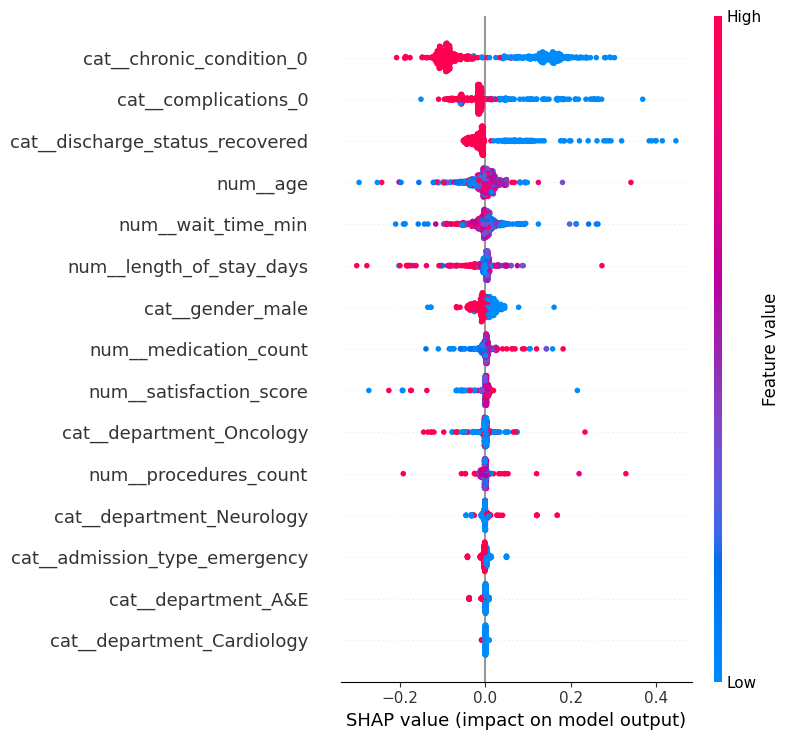

In [55]:
from matplotlib import pyplot as plt

# SHAP beeswarm plot
used = np.where(dt_clf.feature_importances_ > 0)[0]

X_test_used = X_test_dt[:, used]
shap_used   = shap_dt_c1[:, used]
names_used  = [dt_feature_names[i] for i in used]

shap.summary_plot(
    shap_used,
    X_test_used,
    feature_names=names_used,
    show=False
)
plt.tight_layout()
plt.show()

In [56]:
# XGBoost
expl_xgb = shap.TreeExplainer(xgb_clf)
shap_xgb = expl_xgb.shap_values(X_test_xgb)

if isinstance(shap_xgb, list) and len(shap_xgb) == 2:
    shap_xgb_c1 = shap_xgb[1]
else:
    shap_xgb_c1 = shap_xgb

print("XGB SHAP shape (class 1):", np.array(shap_xgb_c1).shape)

XGB SHAP shape (class 1): (600, 21)


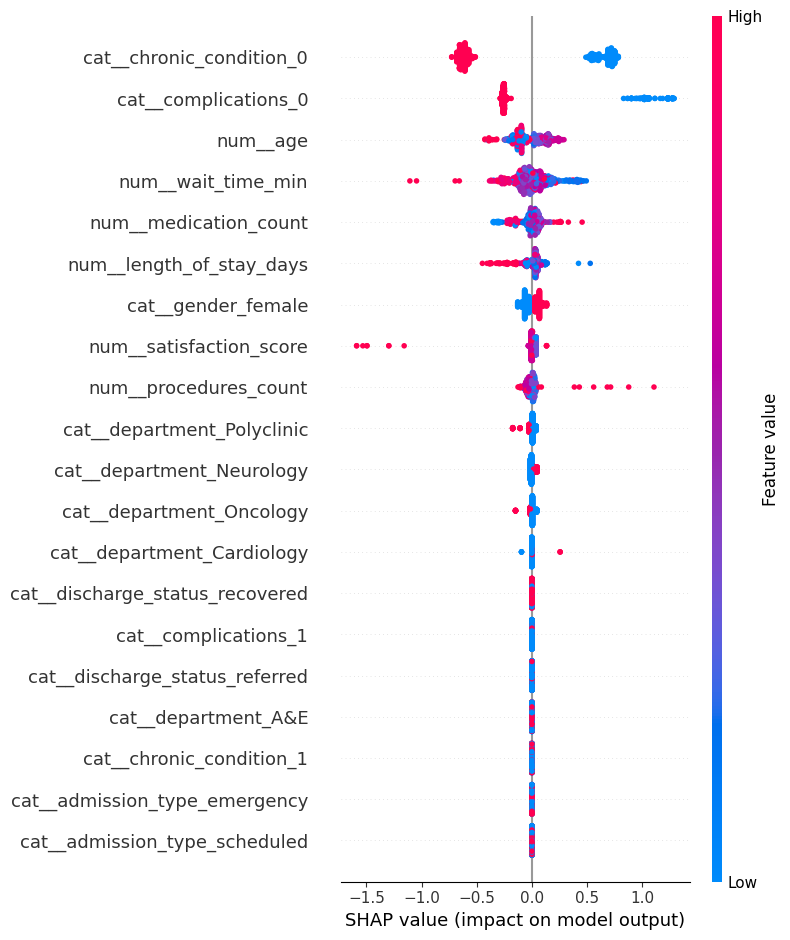

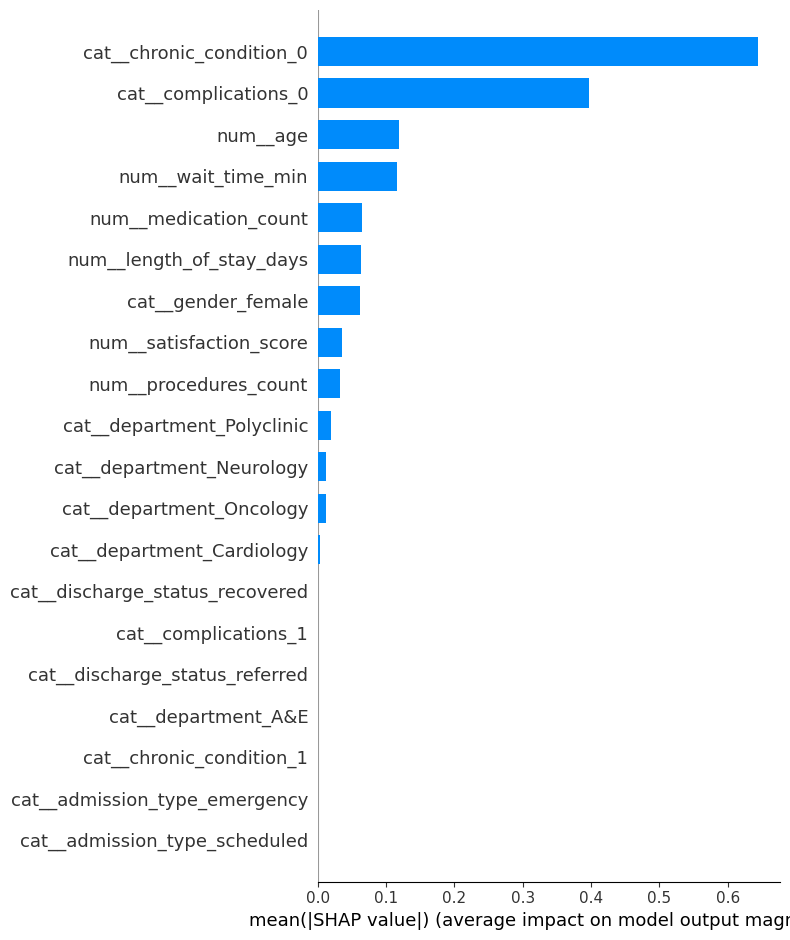

In [57]:
# XGB beeswarm
shap.summary_plot(
    shap_xgb_c1,
    X_test_xgb,
    feature_names=xgb_feature_names,
    show=False
)
plt.tight_layout()
plt.show()

# XGB bar (mean |SHAP|)
shap.summary_plot(
    shap_xgb_c1,
    X_test_xgb,
    feature_names=xgb_feature_names,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.show()

In [58]:
xgb_feature_names[:]

['num__age',
 'num__wait_time_min',
 'num__length_of_stay_days',
 'num__procedures_count',
 'num__medication_count',
 'num__satisfaction_score',
 'cat__gender_female',
 'cat__gender_male',
 'cat__chronic_condition_0',
 'cat__chronic_condition_1',
 'cat__admission_type_emergency',
 'cat__admission_type_scheduled',
 'cat__department_A&E',
 'cat__department_Cardiology',
 'cat__department_Neurology',
 'cat__department_Oncology',
 'cat__department_Polyclinic',
 'cat__complications_0',
 'cat__complications_1',
 'cat__discharge_status_recovered',
 'cat__discharge_status_referred']

In [59]:
import numpy as np

# Mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_xgb_c1).mean(axis=0)

# Sort feature indices by impact (descending)
order = np.argsort(mean_abs_shap)[::-1]

# Sorted feature names (most impactful first)
xgb_feature_names_sorted = [xgb_feature_names[i] for i in order]

# Optional: preview top features
print("Top SHAP features:")
for name, val in zip(xgb_feature_names_sorted[:10], mean_abs_shap[order][:10]):
    print(f"{name:30s}  mean|SHAP| = {val:.4f}")

Top SHAP features:
cat__chronic_condition_0        mean|SHAP| = 0.6442
cat__complications_0            mean|SHAP| = 0.3965
num__age                        mean|SHAP| = 0.1187
num__wait_time_min              mean|SHAP| = 0.1162
num__medication_count           mean|SHAP| = 0.0645
num__length_of_stay_days        mean|SHAP| = 0.0636
cat__gender_female              mean|SHAP| = 0.0618
num__satisfaction_score         mean|SHAP| = 0.0353
num__procedures_count           mean|SHAP| = 0.0329
cat__department_Polyclinic      mean|SHAP| = 0.0194


Using feature: cat__chronic_condition_0


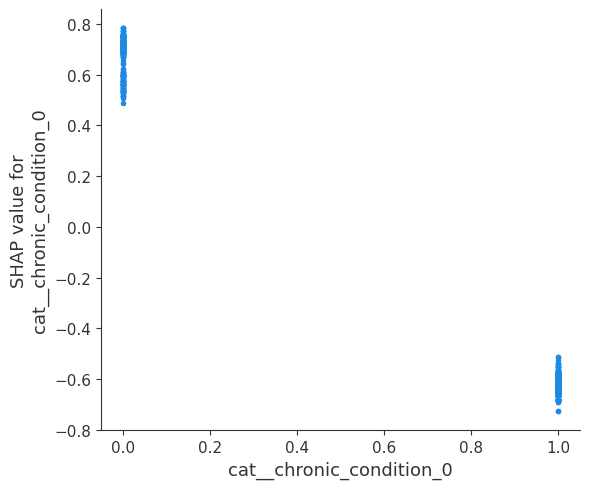

In [60]:
# Pick a feature by name (copy from your SHAP bar plot labels)
# Tip: try xgb_feature_names[:10] to preview candidates
feature_name = xgb_feature_names_sorted[0] # 0 means first feature
print("Using feature:", feature_name)

shap.dependence_plot(
    feature_name,
    shap_xgb_c1,
    X_test_xgb,
    feature_names=xgb_feature_names,
    interaction_index=None,   # <-- removes colour dimension
    show=False
)
plt.tight_layout()
plt.show()

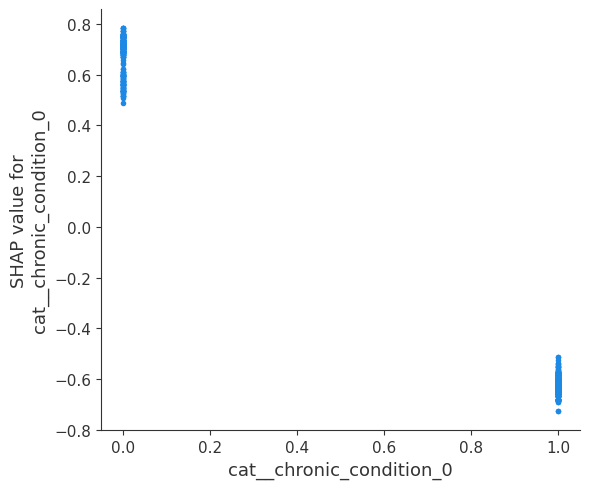

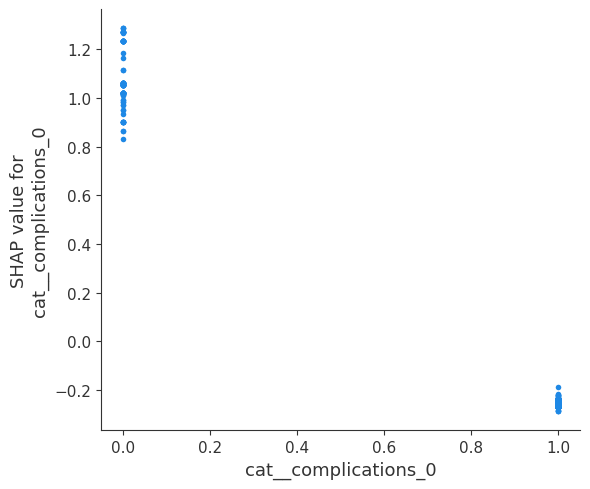

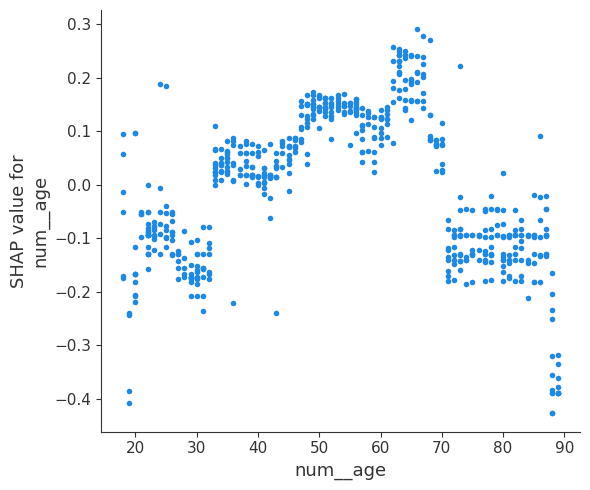

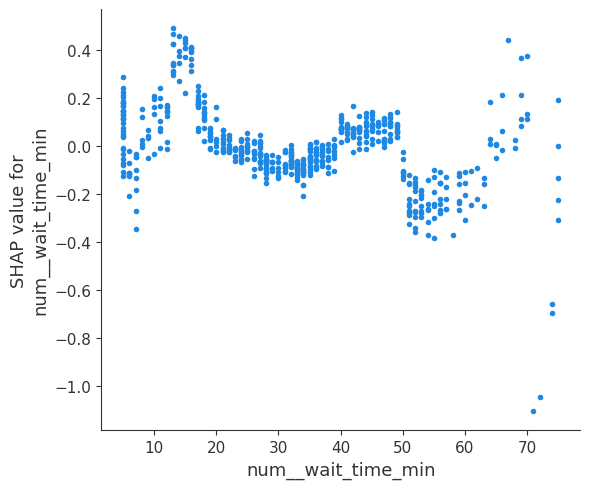

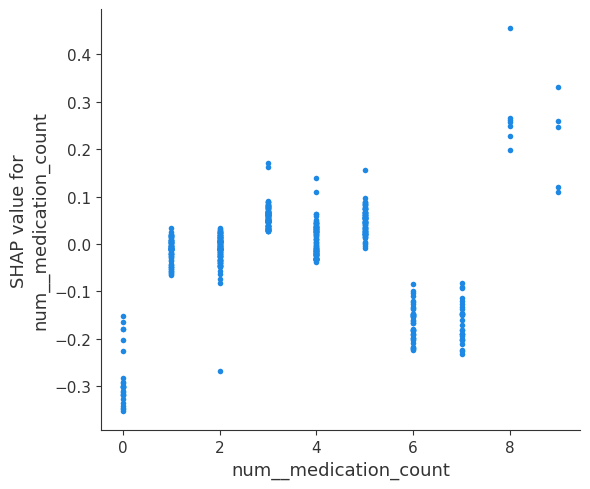

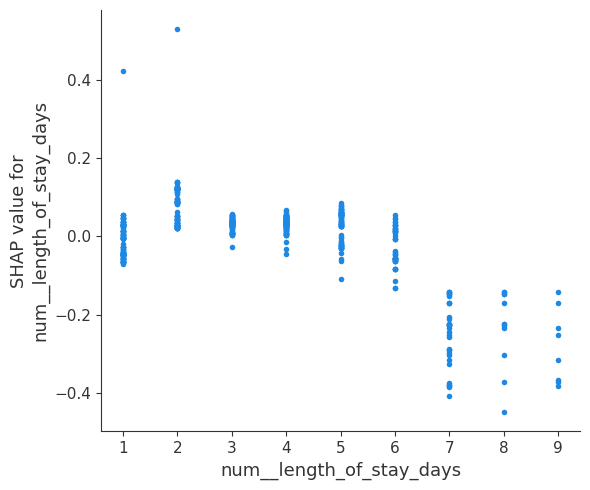

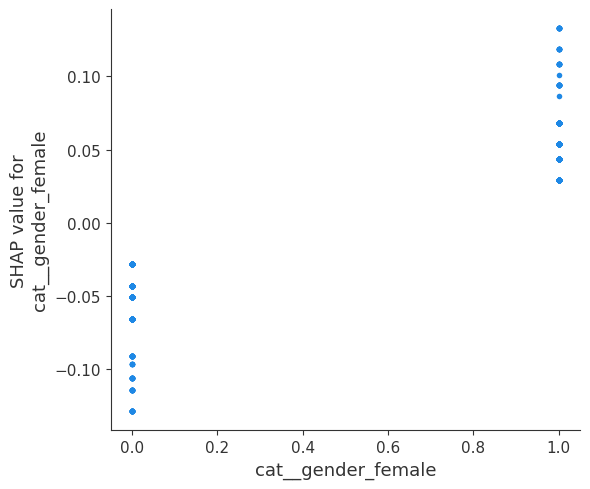

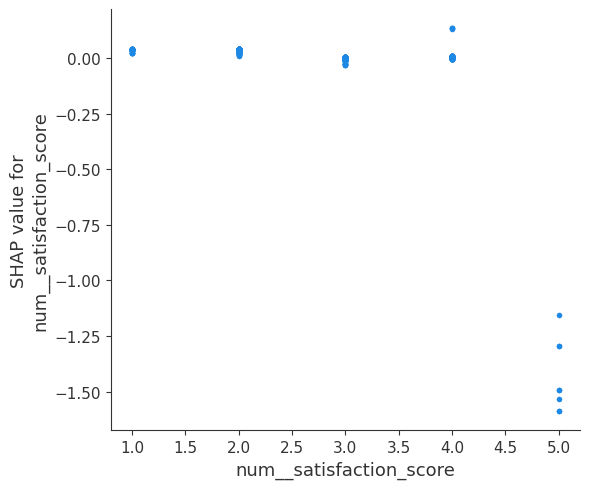

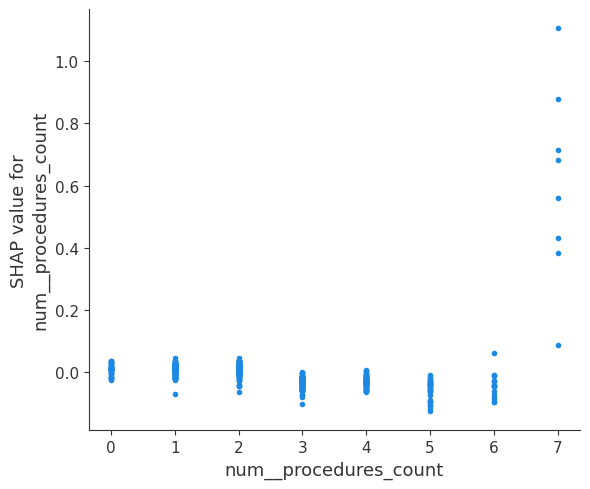

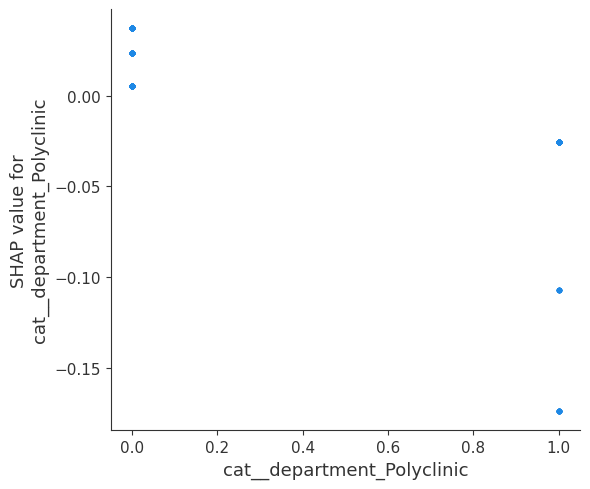

In [ ]:
for feature_name in xgb_feature_names_sorted[:10]:
    shap.dependence_plot(
        feature_name,
        shap_xgb_c1,
        X_test_xgb,
        feature_names=xgb_feature_names,
        interaction_index=None,
        show=False
    )
    plt.tight_layout()
    plt.show()

**Local Explanation**

shap_for_class shape: (600, 21)
baseline (base_for_class): -1.2262925

Chosen true target_class: 1
Chosen feature: cat__chronic_condition_0
Row selection mode: max_pos
Selected row index i (within X_test): 251
Feature SHAP at i: 0.772695

Top contributors for this case (by |SHAP|):
- cat__chronic_condition_0       SHAP= 0.7727 (pushes UP)
- num__length_of_stay_days       SHAP=-0.3248 (pushes DOWN)
- cat__complications_0           SHAP=-0.2201 (pushes DOWN)
- cat__department_Oncology       SHAP=-0.1484 (pushes DOWN)
- num__wait_time_min             SHAP=-0.0895 (pushes DOWN)
- num__age                       SHAP= 0.0876 (pushes UP)
- num__procedures_count          SHAP=-0.0441 (pushes DOWN)
- cat__gender_female             SHAP=-0.0280 (pushes DOWN)
- cat__department_Neurology      SHAP=-0.0123 (pushes DOWN)
- cat__department_Polyclinic     SHAP= 0.0055 (pushes UP)
- num__satisfaction_score        SHAP=-0.0054 (pushes DOWN)
- num__medication_count          SHAP=-0.0047 (pushes DOWN)


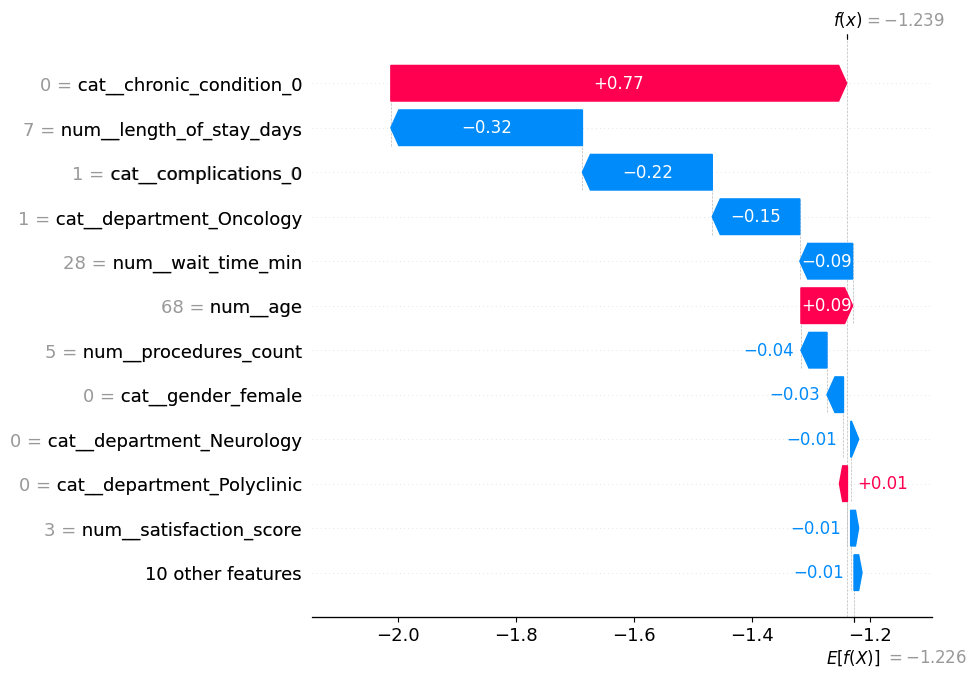

In [61]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) Student choices
# ------------------------------------------------------------
target_class = 1                       # choose 0 or 1 (true label group)
feature_name = xgb_feature_names_sorted[0]

# Choose how to pick the "most interesting" row for this feature:
# - "max_pos"  : row where SHAP(feature) is most positive (pushes UP most)
# - "max_neg"  : row where SHAP(feature) is most negative (pushes DOWN most)
# - "max_abs"  : row where |SHAP(feature)| is largest (strongest impact either way)
# - "near_zero": row where SHAP(feature) is closest to 0 (feature has least impact)
pick_mode = "max_pos"                  # change to: "max_neg", "max_abs", "near_zero"


# ------------------------------------------------------------
# Helper: get SHAP matrix for a chosen class (robust to formats)
# ------------------------------------------------------------
def get_shap_matrix_for_class(explainer, X, target_class: int):
    sv = explainer.shap_values(X)

    # Case A: list of arrays, one per class
    if isinstance(sv, list):
        return sv[target_class], explainer.expected_value[target_class]

    sv = np.asarray(sv)

    # Case B: 3D array (n_samples, n_features, n_classes)
    if sv.ndim == 3:
        base = explainer.expected_value
        base_for_class = base[target_class] if isinstance(base, (list, np.ndarray)) else base
        return sv[:, :, target_class], base_for_class

    # Case C: 2D array (n_samples, n_features) for binary
    # Treat this as the single output explanation (often margin / log-odds)
    base = explainer.expected_value
    base_for_class = base if not isinstance(base, (list, np.ndarray)) else base[0]
    return sv, base_for_class


# ------------------------------------------------------------
# 1) Get SHAP for the chosen class (or single-output fallback)
# ------------------------------------------------------------
shap_for_class, base_for_class = get_shap_matrix_for_class(expl_xgb, X_test_xgb, target_class)

print("shap_for_class shape:", np.asarray(shap_for_class).shape)
print("baseline (base_for_class):", base_for_class)


# ------------------------------------------------------------
# 2) Filter row indices by TRUE label group
# ------------------------------------------------------------
y_test_arr = np.asarray(y_test)
class_idx = np.where(y_test_arr == target_class)[0]
assert len(class_idx) > 0, f"No rows found in y_test for target_class={target_class}"


# ------------------------------------------------------------
# 3) Choose row based on pick_mode for the selected feature
# ------------------------------------------------------------
feat_j = xgb_feature_names.index(feature_name)

shap_vals_feat_in_class = shap_for_class[class_idx, feat_j]

if pick_mode == "max_pos":
    # Most positive SHAP value
    best_pos_in_class = int(np.argmax(shap_vals_feat_in_class))
elif pick_mode == "max_neg":
    # Most negative SHAP value
    best_pos_in_class = int(np.argmin(shap_vals_feat_in_class))
elif pick_mode == "max_abs":
    # Largest absolute SHAP value
    best_pos_in_class = int(np.argmax(np.abs(shap_vals_feat_in_class)))
elif pick_mode == "near_zero":
    # Closest to zero (least impact)
    best_pos_in_class = int(np.argmin(np.abs(shap_vals_feat_in_class)))
else:
    raise ValueError('pick_mode must be one of: "max_pos", "max_neg", "max_abs", "near_zero"')

i = int(class_idx[best_pos_in_class])  # row index in X_test

print(f"\nChosen true target_class: {target_class}")
print(f"Chosen feature: {feature_name}")
print(f"Row selection mode: {pick_mode}")
print(f"Selected row index i (within X_test): {i}")
print(f"Feature SHAP at i: {shap_for_class[i, feat_j]:.6f}")


# ------------------------------------------------------------
# 4) Waterfall for that row
# ------------------------------------------------------------
exp = shap.Explanation(
    values=shap_for_class[i],
    base_values=base_for_class,
    data=X_test_xgb[i],
    feature_names=xgb_feature_names
)

# Top contributors (good for students)
vals = np.asarray(exp.values)
top_idx = np.argsort(np.abs(vals))[::-1][:12]
print("\nTop contributors for this case (by |SHAP|):")
for k in top_idx:
    direction = "pushes UP" if vals[k] > 0 else "pushes DOWN"
    print(f"- {xgb_feature_names[k]:30s} SHAP={vals[k]: .4f} ({direction})")

shap.plots.waterfall(exp, max_display=12)
plt.show()


In [62]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, matthews_corrcoef

mcc_scorer = make_scorer(matthews_corrcoef)

# pFI on full pipeline (permutes raw columns correctly)
pfi_xgb = permutation_importance(
    estimator=xgb_best_pipe,
    X=X_test,
    y=y_test,
    scoring=mcc_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

pfi_series = pd.Series(pfi_xgb.importances_mean, index=X_test.columns).sort_values(ascending=False)

# SHAP global importance on transformed feature space
shap_global = pd.Series(np.abs(shap_xgb_c1).mean(axis=0), index=xgb_feature_names).sort_values(ascending=False)

print("Top raw-column pFI (what hurts MCC if broken):")
display(pfi_series.head(10))

print("Top transformed-feature SHAP (what pushes predictions most):")
display(shap_global.head(10))

Top raw-column pFI (what hurts MCC if broken):


,0
complications,0.237705
chronic_condition,0.123961
age,0.013035
procedures_count,0.011186
wait_time_min,0.007700
medication_count,0.007603
length_of_stay_days,0.003314
admission_type,0.000000
discharge_status,0.000000
department,-0.001911


Top transformed-feature SHAP (what pushes predictions most):


,0
cat__chronic_condition_0,0.644209
cat__complications_0,0.396451
num__age,0.118655
num__wait_time_min,0.116214
num__medication_count,0.064548
num__length_of_stay_days,0.063644
cat__gender_female,0.061784
num__satisfaction_score,0.035260
num__procedures_count,0.032880
cat__department_Polyclinic,0.019398


**Wrap up Prompt**

In [67]:
import numpy as np
import pandas as pd

def summarise_dependence_as_text(
    feature_name: str,
    shap_values_2d,          # shap_xgb_c1: (n_samples, n_features)
    X_2d,                    # X_test_xgb: (n_samples, n_features)
    feature_names: list,
    critical_q=0.90,         # top 10% by |SHAP|
    bins=10                  # for a simple binned trend
):
    j = feature_names.index(feature_name)
    x = np.asarray(X_2d)[:, j]
    s = np.asarray(shap_values_2d)[:, j]

    # 1) Direction (simple correlation as a sign)
    corr = np.corrcoef(x, s)[0, 1]
    direction = "increases" if corr > 0 else "decreases"

    # 2) Turning point (approx where SHAP crosses 0)
    # If it never crosses, report "no crossing"
    sign_change = np.where(np.sign(s[:-1]) != np.sign(s[1:]))[0]
    if len(sign_change) > 0:
        # pick the crossing nearest to s=0 by local min |s|
        k = sign_change[np.argmin(np.abs(s[sign_change]))]
        turning_point = float(np.mean([x[k], x[k+1]]))
        turning_note = f"SHAP crosses 0 around x ≈ {turning_point:.3f}."
    else:
        turning_note = "SHAP does not clearly cross 0 in this sample (mostly one-sided impact)."

    # 3) Critical zone by |SHAP|
    thr = float(np.quantile(np.abs(s), critical_q))
    mask = np.abs(s) >= thr
    if mask.any():
        crit_min = float(np.min(x[mask]))
        crit_max = float(np.max(x[mask]))
        crit_note = (
            f"Critical impact (top {int((1-critical_q)*100)}% by |SHAP|): "
            f"|SHAP| ≥ {thr:.3f} occurs when x is roughly in [{crit_min:.3f}, {crit_max:.3f}]."
        )
    else:
        crit_note = "No points exceed the chosen critical threshold (unexpected)."

    # 4) Typical vs extreme magnitude
    mean_abs = float(np.mean(np.abs(s)))
    max_abs  = float(np.max(np.abs(s)))
    mag_note = f"Average |SHAP| ≈ {mean_abs:.3f}; max |SHAP| ≈ {max_abs:.3f}."

    # 5) Simple binned trend (helps describe ‘when it becomes critical’)
    # bin by feature quantiles for robustness
    qs = np.quantile(x, np.linspace(0, 1, bins + 1))
    # make bins unique (in case of repeated values)
    qs = np.unique(qs)
    if len(qs) >= 3:
        bin_ids = np.digitize(x, qs[1:-1], right=True)
        bin_summary = []
        for b in range(bin_ids.min(), bin_ids.max() + 1):
            xb = x[bin_ids == b]
            sb = s[bin_ids == b]
            if len(xb) == 0:
                continue
            bin_summary.append({
                "x_range": f"[{np.min(xb):.3f}, {np.max(xb):.3f}]",
                "mean_shap": float(np.mean(sb)),
                "mean_abs_shap": float(np.mean(np.abs(sb))),
                "n": int(len(xb))
            })
        bin_df = pd.DataFrame(bin_summary).sort_values("x_range")
        # take the 3 bins with largest mean_abs_shap
        top_bins = bin_df.sort_values("mean_abs_shap", ascending=False).head(3)
        bins_note = "Most impactful value ranges (by mean |SHAP|):\n" + top_bins.to_string(index=False)
    else:
        bins_note = "Binned trend unavailable (feature has too few unique values)."

    # Final text blob (student-friendly, API-friendly)
    text = (
        f"Dependence summary for feature: {feature_name}\n"
        f"- Overall trend: as {feature_name} increases, SHAP contribution generally {direction} "
        f"(corr ≈ {corr:.3f}).\n"
        f"- {turning_note}\n"
        f"- {crit_note}\n"
        f"- {mag_note}\n"
        f"- {bins_note}\n"
        f"Caveat: This is model-driven association, not proof of causation."
    )

    return text

# Example usage
feature_name = xgb_feature_names_sorted[0]
summary_text = summarise_dependence_as_text(
    feature_name=feature_name,
    shap_values_2d=shap_xgb_c1,
    X_2d=X_test_xgb,
    feature_names=xgb_feature_names,
    critical_q=0.90,
    bins=10
)

print(summary_text)


Dependence summary for feature: cat__chronic_condition_0
- Overall trend: as cat__chronic_condition_0 increases, SHAP contribution generally decreases (corr ≈ -0.996).
- SHAP crosses 0 around x ≈ 0.500.
- Critical impact (top 9% by |SHAP|): |SHAP| ≥ 0.727 occurs when x is roughly in [0.000, 1.000].
- Average |SHAP| ≈ 0.644; max |SHAP| ≈ 0.783.
- Binned trend unavailable (feature has too few unique values).
Caveat: This is model-driven association, not proof of causation.


In [68]:
import numpy as np

TOP_N = 8  #typically 3–5 is ideal for students

mean_abs_shap = np.abs(shap_xgb_c1).mean(axis=0)
order = np.argsort(mean_abs_shap)[::-1]
top_feature_names = [xgb_feature_names[i] for i in order[:TOP_N]]

print("Top features by mean |SHAP|:")
for f in top_feature_names:
    print("-", f)


Top features by mean |SHAP|:
- cat__chronic_condition_0
- cat__complications_0
- num__age
- num__wait_time_min
- num__medication_count
- num__length_of_stay_days
- cat__gender_female
- num__satisfaction_score


In [69]:
dependence_summaries = []

for fname in top_feature_names:
    txt = summarise_dependence_as_text(
        feature_name=fname,
        shap_values_2d=shap_xgb_c1,
        X_2d=X_test_xgb,
        feature_names=xgb_feature_names,
        critical_q=0.90,
        bins=10
    )
    dependence_summaries.append(txt)


In [70]:
payload_text = f"""
You are supporting decision-making using a trained XGBoost binary classification model.

IMPORTANT CONTEXT:
- Interpretations are based on SHAP values (model-driven, not causal).
- SHAP values are on the model output scale.
- Recommendations must consider MULTIPLE features together.

TASK:
1) Based on the SHAP evidence below, give 3 data-driven decision recommendations.
2) Each recommendation must reference at least TWO features.
3) State one risk or limitation per recommendation.
4) Propose 2 monitoring checks to detect drift or instability.

GLOBAL CONTEXT:
Top {TOP_N} features selected by mean absolute SHAP impact.

FEATURE-LEVEL DEPENDENCE SUMMARIES
(Each summary is auto-generated from SHAP dependence data):

{"\n\n".join(dependence_summaries)}

OUTPUT RULES:
- Do not treat any single feature as causal.
- Use short bullet points.
- Explicitly mention interactions or reinforcement between features.
""".strip()

print(payload_text)


You are supporting decision-making using a trained XGBoost binary classification model.

IMPORTANT CONTEXT:
- Interpretations are based on SHAP values (model-driven, not causal).
- SHAP values are on the model output scale.
- Recommendations must consider MULTIPLE features together.

TASK:
1) Based on the SHAP evidence below, give 3 data-driven decision recommendations.
2) Each recommendation must reference at least TWO features.
3) State one risk or limitation per recommendation.
4) Propose 2 monitoring checks to detect drift or instability.

GLOBAL CONTEXT:
Top 8 features selected by mean absolute SHAP impact.

FEATURE-LEVEL DEPENDENCE SUMMARIES
(Each summary is auto-generated from SHAP dependence data):

Dependence summary for feature: cat__chronic_condition_0
- Overall trend: as cat__chronic_condition_0 increases, SHAP contribution generally decreases (corr ≈ -0.996).
- SHAP crosses 0 around x ≈ 0.500.
- Critical impact (top 9% by |SHAP|): |SHAP| ≥ 0.727 occurs when x is roughly in

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist working with medical expertise.
You understand tree-based models and SHAP explanations.
You must reason strictly from the provided SHAP evidence and dataset context.
You may draw reasonable conclusion and assumption from the context provided.
""",
    input=f"""
Dataset context:
- Dataset: scikit-learn Breast Cancer dataset
- Task: Binary classification (malignant vs benign)
- Model: XGBoost
- Interpretation method: SHAP (model-driven, log-odds scale)

Model interpretation evidence:
{payload_text}

Questions:

1. From a clinical decision-support perspective, how should recommendations be formed when using the model.

2. Based on the SHAP evidence across the important features, identify the strongest combined risk patterns the model appears to use, for clinician decision-making,
especially for the data ranges and combinations where training data is scarce.

3. Propose 3 decision-support recommendations that a medical expert could reasonably make using this model output.

4. Suggest 2 post-deployment monitoring checks to ensure these SHAP-based patterns remain stable and clinically sensible over time.

Rules:
- Use language to help non medically trained personels to understand.
- Treat the model as an aid to expert judgement, not a replacement.
- Base all reasoning on the SHAP evidence provided.
"""
)

print(response.output_text)


Quick note before answers: SHAP values here are on the model output (log‑odds) scale — a positive SHAP contribution pushes the model toward the positive class (assumed malignant). All statements below are model-driven associations (not causal). Do not base clinical decisions on any single feature alone; use the model as an aid to expert judgement.

1) How recommendations should be formed (clinical decision‑support principles)
- Combine multiple features: use joint patterns (e.g., chronic_condition_0 + complications_0, or age + wait_time_min) rather than one feature alone because the model’s signal comes from interactions/reinforcement.
- Present direction and confidence: show SHAP contributions (which features push the prediction up or down) and flag when those contributions come from rare data regions (low sample counts).
- Recommend actions of intermediate invasiveness: suggest extra monitoring, expedited imaging, or specialist review rather than immediate irreversible procedures bas